In [1]:
import ROOT
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 

import jp_mpl as jplot

from scipy import optimize

# My tools
import jp_analysis as analysis
from copy import deepcopy
reload(analysis)
import reflection_fit
reload(reflection_fit)

ImportError: No module named ROOT

In [2]:
c = 0.299792458*1000 # mm/ns, same as in Geant4

In [3]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))

In [4]:
shadowed= pickle.load(open('/home/jpyanez/snoplus/data/SOC_shadows/SOC_0000017375.pckl'))

In [8]:
#infile = ROOT.TFile('/home/jpyanez/snoplus/data/n16/ResolMC_FitMPW_N16_rat631_x0100_y0100_z0100.root')
#infile = ROOT.TFile('/home/jpyanez/snoplus/data/n16/ResolMC_FitMPW_N16_rat631_x0000_y0000_z0000.root')
infile = ROOT.TFile('/home/jpyanez/snoplus/data/n16/Merged_Fit_100934.root')

hist = infile.Get('htResVsPMTID')
x_bins = hist.GetNbinsX()
y_bins = hist.GetNbinsY()
tcenters = np.zeros(y_bins)
bins = np.zeros((x_bins,y_bins))
for y_bin in xrange(y_bins):
    tcenters[y_bin] = hist.GetYaxis().GetBinCenter(y_bin)
    for x_bin in xrange(x_bins): 
        bins[x_bin,y_bin] = hist.GetBinContent(x_bin + 1,y_bin + 1)
tedges = np.concatenate((tcenters - 0.5, [tcenters[-1]+0.5]))
infile.Close()

In [28]:
# Realign the histogram - do it once, and save it
rbins = np.zeros_like(bins)
reference = bins[1,:]
for iPMT in range(0, rbins.shape[0]):
    rbins[iPMT,:] = analysis.alignHistogram(reference = bins[1,:],
                                   test = bins[iPMT, :])

In [29]:
obins = deepcopy(bins)

/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app


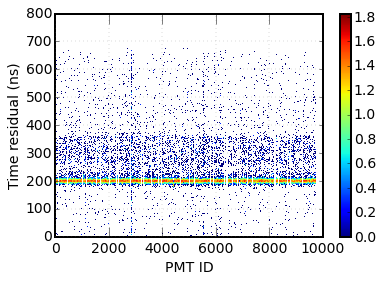

In [30]:
# This is the realigned histogram
plt.imshow(np.log10(rbins.T), interpolation='nearest', aspect='auto',
          origin='lower')
plt.colorbar()
plt.ylabel('Time residual (ns)')
plt.xlabel('PMT ID')

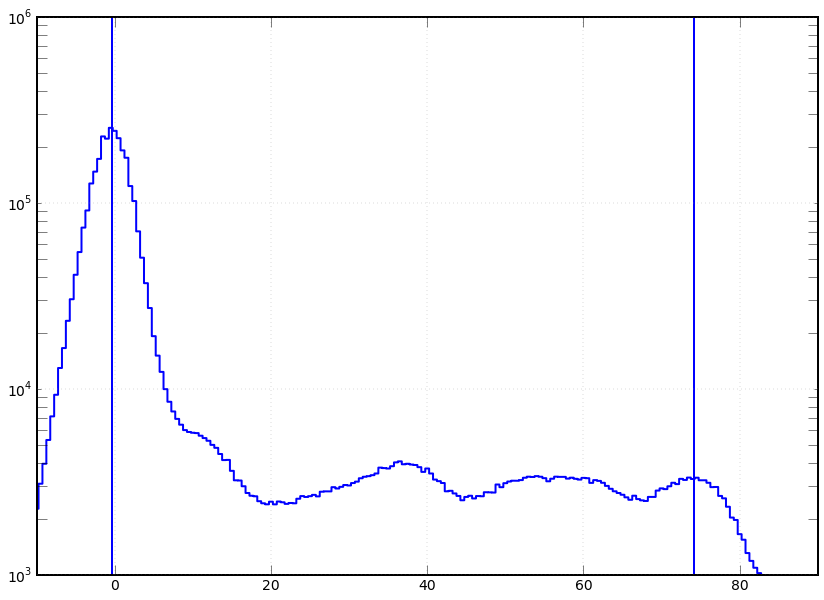

In [37]:
plt.figure(figsize=(14,10))
jplot.unfilledBar(tedges, rbins.sum(axis=0))
plt.yscale('log')
plt.xlim(-10, 90)
plt.ylim(10**3, 10**6)
plt.axvline(x=-0.4, ymin=0, ymax=10**6)
plt.axvline(x=74.1, ymin=0, ymax=10**6)

In [3]:
effvel = 2.*8390./(74.5)
print 'Effective group velocity', effvel
print 'Effective refractive index', c/effvel

Effective group velocity 225.234899329
Effective refractive index 1.33102134213


/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


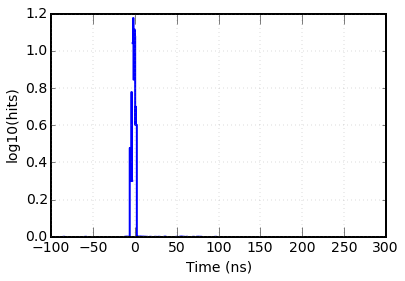

In [11]:
jplot.unfilledBar(tedges, np.log10(bins[1,:]))
#plt.xlim([240, 300])
plt.ylabel('log10(hits)')
plt.xlabel('Time (ns)')

In [12]:
def getTimeDiff(n = None,
                ybins = None,
                ycenters = None,
                peak_width=4., # in ns 
                peak_width2 = 3.,
                
                expected_tdelay = 76.,
                plot = False,
                debug = False):
    
    bin_width = ybins[1]-ybins[0]
    
    # Find the highest peak
    prompt_peak_index = n.argmax()
    
    # First peak range (in bins)
    fit_s = prompt_peak_index - int(peak_width/bin_width)
    fit_e = prompt_peak_index + int(peak_width/bin_width)
    
    
    # Fit a gaussian +/- 4. ns around the peak
    popt =  [n[prompt_peak_index]/2., ycenters[prompt_peak_index],3.]
    try:
        popt, pcov = optimize.curve_fit(analysis.gaus,
                                        ycenters[fit_s:fit_e+1],
                                        n[fit_s:fit_e+1],
                                        popt,
                                       )
        perr = np.sqrt(np.diag(pcov))
        terr1 = perr[1]
        t1 = popt[1]
    except:
        terr1 = np.nan
        t1 = np.nan
    
    # Fit a gaussian around the second peak
    refl_peak_index = prompt_peak_index + int(expected_tdelay/bin_width)
    fit_s2 = refl_peak_index - int(peak_width2/bin_width)
    fit_e2 = refl_peak_index + int((peak_width2*2)/bin_width)
    fit_e2 = np.min([fit_e2, ybins.size-1])
    
    if refl_peak_index > (ybins.size-1):
        terr2 = np.nan
        t2 = np.nan
    else:   
        # Fit a gaussian +/- 4. ns around the peak
        try:
            popt2 = [n[refl_peak_index]/2.,ycenters[refl_peak_index],3.]
            popt2, pcov2 = optimize.curve_fit(analysis.gaus,
                                              ycenters[fit_s2:fit_e2+1],
                                              n[fit_s2:fit_e2+1],
                                              popt2)   
            perr2 = np.sqrt(np.diag(pcov2))
            terr2 = perr2[1]
            t2 = popt2[1]
        except RuntimeError: 
            terr2 = np.nan
            t2 = np.nan
    

    if plot:
        fig = plt.figure(figsize=(7,4))
        ax1 = fig.add_subplot(111)
        jplot.unfilledBar(ybins, n, color='0.7')

        newx = np.linspace(ycenters[fit_s]-3., ycenters[fit_e]+3., 101)
        plt.plot(newx, analysis.gaus(newx, *popt), 'r')
        
        try:
            newx = np.linspace(ycenters[fit_s2]-3., ycenters[fit_e2]+3., 101)
            plt.plot(newx, analysis.gaus(newx, *popt2), 'r')    
            plt.xlim([ycenters[prompt_peak_index]-20., ycenters[refl_peak_index] + 20])
        except:
            print 'Could not plot second gaus (out of bounds)'
        
        plt.yscale('log')
        plt.ylabel('N hits')
        plt.ylim([1., n[prompt_peak_index]*1.3])

        return fig
    
        #raw_input()
    return t1, terr1, t2, terr2

### Going over the dimension, selecting PMTs

In [86]:
class FitLBpos(object):
    def __init__(self,
                 data = None,
                 error = None,
                 pmt_xyz = None,
                 pmtbool = None,
                 psup_radius = 8390.,
                 water_n = 1.34389,
                 print_call = True):
        self.c            = 0.299792458*1000 # mm/ns
        self.data    = deepcopy(data)
        self.pmt_xyz = deepcopy(pmt_xyz)
        self.pmtbool = deepcopy(pmtbool)
        self.pmt_r   = np.linalg.norm(pmt_xyz,axis=1)
        self.header_done = False

        self.R = psup_radius
        #self.water_c = c/water_n
        self.print_call = print_call
        
        self.pmtbool[self.data == 0] = False
        
        if error == None:
            self.error = np.ones_like(data)
        else:
            self.error = error + 1 # Adding one ns for everything
    
    def print_eval_header(self):
        print 'FCN \t\t u \t v \t w \t n'
        self.header_done = True
        
    def print_eval(self, value, u, v, w, n):
        if not self.header_done:
            self.print_eval_header()
        print value, '\t', u, '\t', v, '\t', w, '\t', n
        
    def __call__(self, u, v, w, n):
        this_pos = np.array([ u, v, w])
        water_c = self.c/n
        tdiff = 2*self.R/water_c* \
                (1+np.dot(self.pmt_xyz,this_pos)/(self.pmt_r*self.R))
        
        delta = (tdiff - self.data)[self.pmtbool]**2/self.error[self.pmtbool]**2
        delta = np.sum(delta)
        
        if self.print_call:
            self.print_eval(delta, u, v, w, n)
        
        return delta

In [13]:
pmtbool = (pmt_info['type'] == 1)+(pmt_info['type'] == 7) * ~shadowed


In [118]:
psup_radius = 8390.
n = 1.383
zmin = -6000

## Doing the fit all together, splitting by angular region

In [119]:
shifted_sum = True
if shifted_sum:
    bins = rbins
else:
    bins = obins

# Bin in costheta and phi
phi_slices = 10
ct_slices  = 20

pmtbool = (pmt_info['type'] == 1)+(pmt_info['type'] == 7)

phi_edges = np.linspace(-np.pi, np.pi, phi_slices + 1)
ct_edges  = np.linspace(-1, 1, ct_slices + 1)

tof = np.zeros([phi_slices*ct_slices,4])
slice_xyz = np.zeros([phi_slices*ct_slices, 3])
slice_npmt = np.zeros(phi_slices*ct_slices)

iBin = 0
for iPhi in range(phi_slices):
    for iCt in range(ct_slices):
        
        # Select pmts in this angular range
        angbool = ((pmt_info['phi'] > phi_edges[iPhi]) * 
                   (pmt_info['phi'] < phi_edges[iPhi+1])*
                   (pmt_info['costheta'] > ct_edges[iCt])*
                   (pmt_info['costheta'] < ct_edges[iCt+1]))
        
        slice_npmt[iBin] = np.sum(angbool*pmtbool)
        if slice_npmt[iBin] == 0:
            tof[iBin,:] = [np.nan, np.nan, np.nan, np.nan]
            continue
            
        slice_xyz[iBin,:] = pmt_info['xyz'][angbool*pmtbool,:].mean(axis=0)
        
        newbins = np.sum(bins[pmtbool*angbool, :], axis=0)
        
        #print newbins.shape, tedges.shape, tcenters.shape
        
        tof[iBin,:] = getTimeDiff(n = newbins,
                                  ybins = tedges,
                                  ycenters = tcenters,
                                  expected_tdelay = 77.,
                                  peak_width2 = 4.,
                                  plot = False)        
        
        iBin += 1


### This is Jie's fit, each dimension at a time

Valid PMT sections 200 out of  200


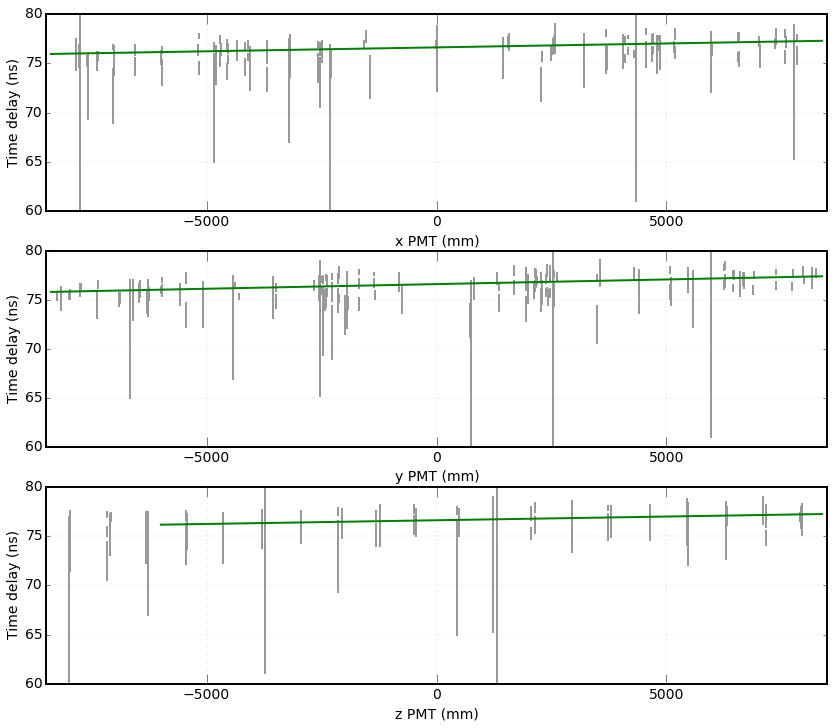

In [120]:
valid = (~np.isnan(tof[:,0]))*(~np.isnan(tof[:,2]))
print 'Valid PMT sections', np.sum(valid), 'out of ', tof.shape[0]
tdelay = tof[:,2] - tof[:,0]
tderr  = np.sqrt(tof[:,1]**2 + tof[:,3]**2)
fig = plt.figure(figsize=(14,12))

refl_fit = np.zeros([3,2])
refl_err = np.zeros([3,2])

newaxis = np.linspace(-psup_radius, psup_radius, 1001)
zaxis = np.linspace(zmin, psup_radius, 1001)
plotaxes = [newaxis, newaxis, zaxis]

axes_names = ['x','y','z']
for iAx in range(3):

    fig.add_subplot(3,1,iAx+1)
    plt.errorbar(x = slice_xyz[valid, iAx], 
                 y = tdelay[valid],
                 yerr = tderr[valid],
                 fmt = 'none', elinewidth=2., capsize=0., ecolor = '0.6')
    
    if iAx == 2: # Additional constraint for the validity of PMTs in Z
        valid *= slice_xyz[:,iAx] > zmin
    p0 = [0., 2*psup_radius/(c/1.3)]
    xfit,xcov = optimize.curve_fit(f = analysis.line_fcn,
                                    xdata = slice_xyz[valid, iAx],
                                    ydata = tdelay[valid],
                                    p0 = p0,
                                    sigma = tderr[valid]
                                    )        
    refl_fit[iAx,:] = xfit
    refl_err[iAx,:] = np.sqrt(np.diag(xcov))

    plt.plot(plotaxes[iAx], 
             analysis.line_fcn(plotaxes[iAx], *xfit), '-g') 
    
    plt.ylabel('Time delay (ns)')
    plt.xlabel(axes_names[iAx] + ' PMT (mm)')
    plt.ylim([60, 80])
    plt.xlim([-8500, 8500])
    

In [121]:
print 'Calculating the positions'
psup_radius = 8390.
n = 1.383
for iAx in range(3):
    print axes_names[iAx], '=', refl_fit[iAx,0]*(c/n)*psup_radius/2., \
        '+/-', refl_err[iAx,0]*(c/n)*psup_radius/2.

Calculating the positions
x = 72.2960691053 +/- 11.0629585979
y = 85.891334438 +/- 10.1537824483
z = 68.4342575193 +/- 14.8235849599


## This is my fit, all 3 and n at once

In [122]:
sourcefit = FitLBpos( data = tdelay,
                      error = tderr,
                      pmt_xyz = slice_xyz,
                      pmtbool = valid,
                      print_call = False)

/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [123]:
wrapfcn = lambda p: sourcefit(*p)
my_x0 = np.array([10., 10., 10., 1.3])
fit = optimize.minimize(wrapfcn,
                        x0 = my_x0,
                        method = 'SLSQP',
                        bounds=((-6500,6500),
                                (-6500,6500),
                                (-6500,6500),
                                (0.5, 2.)),
                        options={'ftol':1E-7, 'maxiter':1000})
fit.x

array([ 78.60469739,  96.27926335,  79.10316982,   1.36457781])

## Doing the fit one dimension at a time, redoing slices

Average nPMTs 276.176470588
Average nPMTs 276.235294118
Average nPMTs 276.147058824


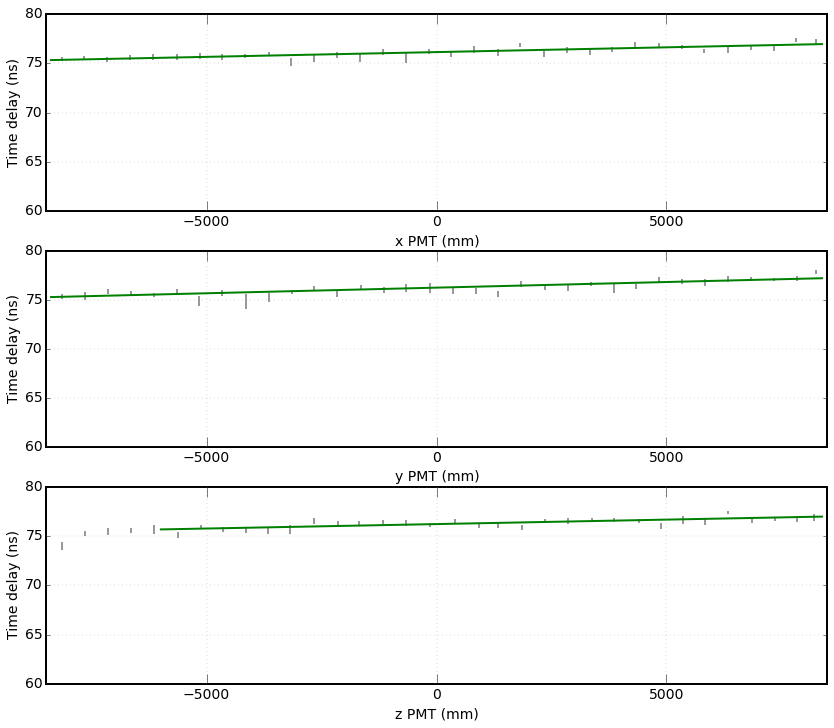

In [130]:
fig = plt.figure(figsize=(14,12))

shifted_sum = True
if shifted_sum:
    bins = rbins
else:
    bins = obins
    
zmin = -6000

# The PMTs need to be selected according to their position in X, Y, Z
axes_names = ['x','y','z']
axes = [0, 1, 2]
tol  = 500 # in mm
pmtbool = (pmt_info['type'] == 1)+(pmt_info['type'] == 7)
psup_radius = 8390.


newaxis = np.linspace(-psup_radius, psup_radius, 1001)
zaxis = np.linspace(zmin, psup_radius, 1001)
plotaxes = [newaxis, newaxis, zaxis]

refl_fit = np.zeros([3,2])
refl_err = np.zeros([3,2])

for iAx in range(len(axes)):
    xmax = pmt_info['xyz'][pmtbool,axes[iAx]].max()
    xmin = pmt_info['xyz'][pmtbool,axes[iAx]].min()
    pmt_bins = int(np.ceil((xmax-xmin)/tol))
    npmts = np.zeros(pmt_bins)
    
    tof = np.zeros([pmt_bins,4])
    xpos   = np.zeros(pmt_bins)
    

    for iBin in range(pmt_bins):
        rangebool = ((pmt_info['xyz'][:,iAx] > (xmin+iBin*tol) ) * 
                     (pmt_info['xyz'][:,iAx] < (xmin+(iBin+1)*tol)))
        #print 'Bin ', iBin, '- PMTs in range', np.sum(rangebool)
        npmts[iBin] = np.sum(rangebool*pmtbool)
        if np.sum(rangebool*pmtbool) == 0:
            tof[iBin,:] = np.nan
            xpos[iBin] = np.nan
            continue
        newbins = np.sum(bins[pmtbool*rangebool, :], axis=0)
        
        xpos[iBin] = pmt_info['xyz'][pmtbool*rangebool, iAx].mean()
        
        tof[iBin,:] = getTimeDiff(n = newbins,
                                     ybins = tedges,
                                     ycenters = tcenters,
                                     expected_tdelay = 77.,
                                     peak_width2 = 4.,
                                     plot = False)
        
    # After selecting PMTs and finding peaks, it is time to fit
        
    # PMTs with valid fits
    valid = (~np.isnan(tof[:,0]))*(~np.isnan(tof[:,2]))

        
        
    tdelay = tof[:,2] - tof[:,0]
    tderr  = np.sqrt(tof[:,1]**2 + tof[:,3]**2)
    fig.add_subplot(3,1,iAx+1)
    plt.errorbar(x = xpos[valid], 
                 y = tdelay[valid],
                 yerr = tderr[valid],
                fmt = 'none', elinewidth=2., capsize=0., ecolor = '0.6')
    
    if iAx == 2: # Additional constraint for the validity of PMTs in Z
        valid *= xpos > zmin
    p0 = [0., 2*psup_radius/(c/1.3)]
    xfit,xcov = optimize.curve_fit(f = analysis.line_fcn,
                                    xdata = xpos[valid],
                                    ydata = tdelay[valid],
                                    p0 = p0,
                                    sigma = tderr[valid]
                                    )        
    refl_fit[iAx,:] = xfit
    refl_err[iAx,:] = np.sqrt(np.diag(xcov))

    plt.plot(plotaxes[iAx], 
             analysis.line_fcn(plotaxes[iAx], *xfit), '-g') 
    
    plt.ylabel('Time delay (ns)')
    plt.xlabel(axes_names[iAx] + ' PMT (mm)')
    plt.ylim([60, 80])
    plt.xlim([-8500, 8500])
    
    

        
    print 'Average nPMTs', npmts.mean()

    


In [131]:
print 'Calculating the positions'
psup_radius = 8390.
n = 1.383
for iAx in range(3):
    print axes_names[iAx], '=', refl_fit[iAx,0]*(c/n)*psup_radius/2., \
        '+/-', refl_err[iAx,0]*(c/n)*psup_radius/2.

Calculating the positions
x = 87.9897063301 +/- 8.56873347287
y = 103.701295774 +/- 9.18905961093
z = 82.2299447062 +/- 13.377587938
